In [184]:
import qiime2
import torch
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import StratifiedKFold
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import numpy as np

In [67]:
fungi_decontaminated = 'data/count_data_fungi_decontaminated_HMS_1986samples.tsv'
fungi_metadata = 'data/metadata_fungi_HMS_1986samples.tsv'


In [68]:
fungi_decon = pd.read_csv(fungi_decontaminated, sep='\t', header=0)
fungi_decon = fungi_decon.set_index('sampleid')

metadata = pd.read_csv(fungi_metadata, sep='\t', header=0)
metadata = metadata.set_index('sampleid')

In [69]:
fungi_decon.head()

,sampleid,G000001985,G000002515,G000002525,G000002545,G000002655,G000002715,G000002855,G000002945,G000003125,...,G009193645,G010015585,G010093625,G010724455,G011692745,G900007375,G900067095,G900074925,G900079805,G000277815
0,13722.58cfa82fe4b0c9d6adf6b62c,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,4,0,0
1,13722.58cfa82fe4b0c9d6adf6b5e0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,2,0,0
2,13722.58cfa82ee4b0c9d6adf6af8e,1,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,977,0,0
3,13722.58cfa82ee4b0c9d6adf6af20,0,0,0,0,2,2,0,0,0,...,5,0,0,0,0,0,0,182,0,0
4,13722.58cfa82fe4b0c9d6adf6b669,0,0,0,0,1,1,0,0,0,...,2,0,0,0,0,0,0,6,0,0


In [71]:
metadata_cols = ['disease_type','sample_type'] 
metadata = metadata[metadata_cols] #grab needed columns
metadata = metadata[metadata['sample_type'] == 'Primary Tumor'] #filter only Primary Tumors
#drop cancers with less than 20 samples
metadata = metadata[metadata['disease_type'].map(metadata['disease_type'].value_counts()) > 20]  
metadata.head()

,disease_type,sample_type
sampleid,,
13722.58cfa82fe4b0c9d6adf6b62c,Lung Adenocarcinoma,Primary Tumor
13722.58cfa82ee4b0c9d6adf6af20,Lung Adenocarcinoma,Primary Tumor
13722.58cfa82fe4b0c9d6adf6b6d8,Lung Adenocarcinoma,Primary Tumor
13722.58cfa82fe4b0c9d6adf6b648,Lung Adenocarcinoma,Primary Tumor
13722.58cfa82fe4b0c9d6adf6b60d,Lung Adenocarcinoma,Primary Tumor


In [73]:
labels = pd.get_dummies(metadata['disease_type'])
labels.head()

,Bladder Urothelial Carcinoma,Brain Lower Grade Glioma,Colon Adenocarcinoma,Head and Neck Squamous Cell Carcinoma,Lung Adenocarcinoma,Prostate Adenocarcinoma,Rectum Adenocarcinoma,Stomach Adenocarcinoma,Thyroid Carcinoma,Uterine Corpus Endometrial Carcinoma
sampleid,,,,,,,,,,
13722.58cfa82fe4b0c9d6adf6b62c,0,0,0,0,1,0,0,0,0,0
13722.58cfa82ee4b0c9d6adf6af20,0,0,0,0,1,0,0,0,0,0
13722.58cfa82fe4b0c9d6adf6b6d8,0,0,0,0,1,0,0,0,0,0
13722.58cfa82fe4b0c9d6adf6b648,0,0,0,0,1,0,0,0,0,0
13722.58cfa82fe4b0c9d6adf6b60d,0,0,0,0,1,0,0,0,0,0


In [77]:
samples = labels.index #get relevant sampleID's after cleaning

In [86]:
fungi_decon = fungi_decon.filter(items = samples, axis=0) #filter feature tables for relevant samples

In [88]:
fungi_decon.head()

,G000001985,G000002515,G000002525,G000002545,G000002655,G000002715,G000002855,G000002945,G000003125,G000003515,...,G009193645,G010015585,G010093625,G010724455,G011692745,G900007375,G900067095,G900074925,G900079805,G000277815
sampleid,,,,,,,,,,,,,,,,,,,,,
13722.58cfa82fe4b0c9d6adf6b62c,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,4,0,0
13722.58cfa82ee4b0c9d6adf6af20,0,0,0,0,2,2,0,0,0,0,...,5,0,0,0,0,0,0,182,0,0
13722.58cfa82fe4b0c9d6adf6b6d8,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
13722.58cfa82fe4b0c9d6adf6b648,0,0,0,0,0,1,1,0,0,0,...,1,1,1,0,0,1,2,84188,1,0
13722.58cfa82fe4b0c9d6adf6b60d,0,0,0,0,0,1,1,0,0,0,...,3,0,0,0,0,1,0,59823,0,0


(836, 224)

In [142]:
X = fungi_decon
y = labels

In [168]:
lung_y = y['Lung Adenocarcinoma'].values #array

In [137]:
from sklearn.ensemble import RandomForestClassifier

In [139]:
def cross_validation(model, _X, _y, _cv=10):
    '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
    
    _scoring = ['roc_auc', 'precision', 'recall']
    
    results = cross_validate(estimator=model,
                            X=_X,
                            y=_y,
                            cv=_cv,
                            scoring=_scoring,
                            return_train_score=True)
    
    return {"Training ROC_AUC scores": results['train_roc_auc'],
          "Mean Training ROC_AUC": results['train_roc_auc'].mean()*100,
          "Training Precision scores": results['train_precision'],
          "Mean Training Precision": results['train_precision'].mean(),
          "Training Recall scores": results['train_recall'],
          "Mean Training Recall": results['train_recall'].mean(),
          "Validation ROC_AUC scores": results['test_roc_auc'],
          "Mean Validation ROC_AUC": results['test_roc_auc'].mean()*100,
          "Validation Precision scores": results['test_precision'],
          "Mean Validation Precision": results['test_precision'].mean(),
          "Validation Recall scores": results['test_recall'],
          "Mean Validation Recall": results['test_recall'].mean()
          }


In [140]:
clf = RandomForestClassifier(n_estimators=150, max_depth=3, random_state=0)

In [169]:
clf_result = cross_validation(clf, X, lung_y, _cv=10)

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [170]:
clf_result

{'Training ROC_AUC scores': array([0.88996145, 0.88909983, 0.90757346, 0.88974239, 0.88547812,
        0.89162626, 0.90017789, 0.87957482, 0.88924655, 0.8896227 ]),
 'Mean Training ROC_AUC': 89.12103462243441,
 'Training Precision scores': array([0.96      , 0.96296296, 0.95652174, 1.        , 0.93333333,
        0.92      , 0.96551724, 0.93548387, 1.        , 0.96153846]),
 'Mean Training Precision': 0.9595357609312245,
 'Training Recall scores': array([0.22641509, 0.24528302, 0.20754717, 0.22641509, 0.26415094,
        0.21698113, 0.26415094, 0.27358491, 0.21495327, 0.23364486]),
 'Mean Training Recall': 0.2373126432727914,
 'Validation ROC_AUC scores': array([0.79050926, 0.78819444, 0.85416667, 0.83101852, 0.68287037,
        0.87268519, 0.64084507, 0.8556338 , 0.92424242, 0.81565657]),
 'Mean Validation ROC_AUC': 80.5582230758287,
 'Validation Precision scores': array([0.6       , 0.33333333, 1.        , 0.75      , 0.        ,
        1.        , 0.        , 1.        , 1.        

In [176]:
plt_data = clf_result['Training ROC_AUC scores']

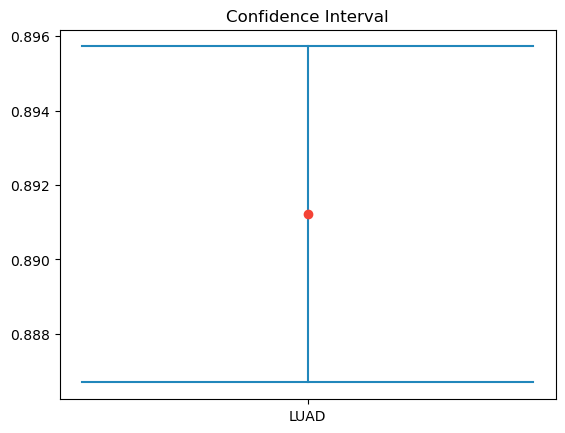

In [185]:
def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = np.mean(values)
    stdev = np.std(values)
    confidence_interval = z * stdev / (len(values)**(1/2))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval


plt.xticks([1], ['LUAD'])
plt.title('Confidence Interval')
plot_confidence_interval(1, plt_data)

plt.show()